# T036 · Uncertainty estimation

**Note:** This talktorial is a part of TeachOpenCADD, a platform that aims to teach domain-specific skills and to provide pipeline templates as starting points for research projects.

Authors:

- Michael Backenköhler, 2022, [Volkamer lab](https://volkarmerlab.org), Saarland University

*The example used in this talktorial template is taken from [__Talktorial T022__](https://github.com/volkamerlab/teachopencadd/blob/master/teachopencadd/talktorials/T022_ligand_based_screening_neural_network/talktorial.ipynb).*

## Aim of this talktorial

Add a short summary of this talktorial's content.

### Contents in *Theory*

* Why a model can't and shouldn't be certain
* Methods overview

### Contents in *Practical*

_Add Table of Contents (TOC) for Practical section._

* Ensembles - Training a model multiple times
    * Coverage of confidence intervals
    * Calibration
    * Ranking based evaluation
* Bagging ensemble - Training a model with varying data
    * Coverage of confidence intervals
    * Calibration
    * Ranking based evaluation

### References

* Paper 
* [__Talktorial T022__](https://github.com/volkamerlab/teachopencadd/blob/master/teachopencadd/talktorials/T022_ligand_based_screening_neural_network/talktorial.ipynb)
* Other useful resources

*We suggest the following citation style:*
* Keyword describing resource: <i>Journal</i> (year), <b>volume</b>, pages (link to resource) 

*Example:*
* ChEMBL web services: [<i>Nucleic Acids Res.</i> (2015), <b>43</b>, 612-620](https://academic.oup.com/nar/article/43/W1/W612/2467881) 

## Theory
Often researchers pay a lot of attention to the quality of the estimation overall.
But to apply any predictive method in practice, it is arguably as important to know how much to _trust_ an estimation.
It would be therefore nice to have not only a point estimate of something but also some indication of how _certain_ we can be about the given estimate.
The certainty is often modeled by replacing the point estimate by a distributional estimate.
For example, a model $f$ on an input does not only predict $f(x)=\hat\theta$ but a normal distribution $f(x)=N(\hat\theta, \hat\sigma)$.

### Why a model can't and shouldn't be certain
Before discussing how to estimate uncertainty, we take a look at the causes of uncertainty.
These are twofold:
1. _Aleatoric_ or _data uncertainty_ is inherent in the data and its source
2. _Epistemic_ or _model uncertainty_ is caused by the limitations of the model
Aleatoric uncertainty is unavoidable because it is inherent in the real system and the way we collect data.
It is uncertainty that remains even if can select infinitely large sets of data.
Imagine you are performing a chemical experiment to determine the binding affinity between some compound and a protein.
Even if you are an outstandingly careful chemist you will probably not be able to exactly reproduce the same $K_d$ each time around.
This uncertainty will always be present in the data. Even if you repeat the experiment until you reach old age.

Model uncertainty is caused by the abstraction our model makes. Our models are not perfect. If they were, we would not need machine learning after all!
Thus, we always introduce some degree of simplification. And this introduces uncertainty into our predictions.

### Methods overview
There is a wide variety of methods providing uncertainty estimates. An excellent survey is given in ___REF___.
Here, we stick with the most common and widely applicable methods.
These can roughly be divided into
1. single deterministic methods and
2. ensemble methods.

#### Single deterministic methods

#### Ensemble methods

![Model ensemble](images/nn.jpg)

### Specific aspects im cheminformatics (?)
* sampling almost compounds is hard to achieve (activity cliffs)

## Practical

Add short summary of what will be done in this practical section.

In [2]:
from pathlib import Path
from warnings import filterwarnings

# Silence some expected warnings
filterwarnings("ignore")

import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import tensorflow as tf

from t022 import neural_network_model, smiles_to_fp, load_chembl_egfr_data, create_and_fit_model

%matplotlib inline

In [3]:
HERE = Path('.').absolute()
DATA = HERE / "data"

Load data.

In [4]:
chembl_df = load_chembl_egfr_data(DATA / "CHEMBL25_activities_EGFR.csv", method='morgan3', n_bits=2024)
x_train, x_test, y_train, y_test = train_test_split(
    chembl_df["fingerprints_df"], chembl_df["pIC50"], test_size=0.3, random_state=42
)
x_test = tf.convert_to_tensor(np.array([np.array(a, dtype=int) for a in x_test], dtype=int))
x_train = tf.convert_to_tensor(np.array([np.array(a, dtype=int) for a in x_train], dtype=int))
y_train = tf.constant(y_train)
y_test = tf.constant(y_test)

2022-12-15 12:40:44.805417: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-15 12:40:44.805779: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-15 12:40:44.807297: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


We now set up the pipeline of creating and training a model.

### Ensembles - Training a model multiple times

In [89]:
ensemble_size = 20
ensemble = []
for _ in tqdm.tqdm(range(ensemble_size)):
    model = create_and_fit_model(x_train, y_train, x_test, y_test,
                                 layers=[1024, 512, 256, 128, 64], verbose=0, batch_size=32, epochs=15)
    ensemble.append(model)

100%|███████████████████████████████████████████| 20/20 [11:58<00:00, 35.93s/it]


In [90]:
preds = np.array([model.predict(x_test) for model in ensemble]).reshape(ensemble_size, len(x_test))

In [91]:
stds = preds.std(0)
var = preds.var(0)
mean = preds.mean(0)
mae = np.abs(preds - y_test).sum(0)
mse = np.sum((preds - y_test) ** 2, 0)

In [92]:
np.corrcoef(mean, y_test)

array([[1.       , 0.8441611],
       [0.8441611, 1.       ]])

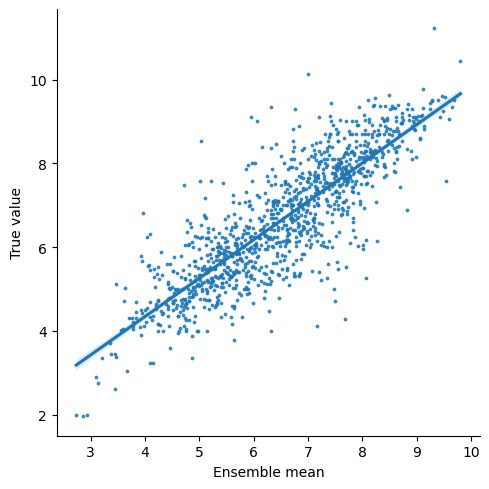

In [93]:
sns.lmplot(pd.DataFrame({'Ensemble mean': mean, 'True value': y_test}), x='Ensemble mean', y='True value', scatter_kws={'s': 3});

Text(0, 0.5, 'MAE')

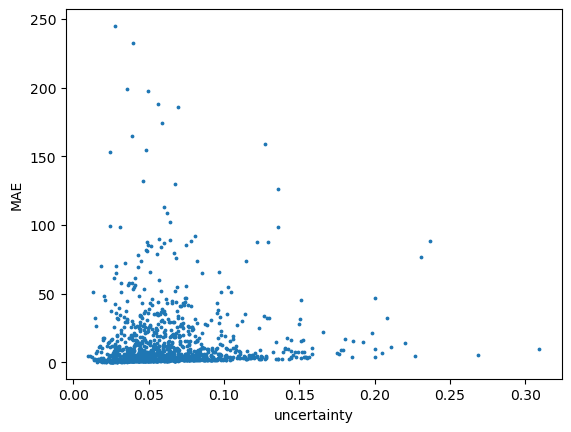

In [94]:
plt.scatter(var, mse, s=3)
plt.xlabel('uncertainty')
plt.ylabel('MAE')
# plt.yscale('log')
# plt.xscale('log')

In [95]:
np.corrcoef(mae, stds)

array([[1.        , 0.02647844],
       [0.02647844, 1.        ]])

#### Coverage of confidence intervals

For each confidence level, we can compute confidence intervals based on the standard deviations, we get out of our model ensemble.
According to the definition of the confidence interval for level $p$, the interval should cover the actual value with probability $p$.
Therefore, if we plot all hit ratios over the test for all levels in $[0,1]$, we ideally would end up with a perfect diagonal (the identiy function).

In [96]:
confidences = np.linspace(0, 1)

hits = []
for c in confidences:
    delta = stds * norm.ppf(.5 + c / 2) / np.sqrt(len(ensemble))
    a = np.array((mean - delta < y_test) & (mean + delta > y_test)).astype(int)
    hits.append(a.sum() / len(a))

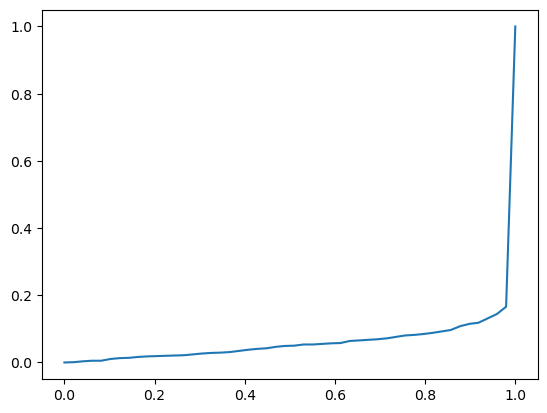

In [98]:
plt.plot(confidences, hits)
plt.yscale('linear')

#### Calibration

First, we compute the confidence curve on a small, dedicated part of the test set. Based on the confidence curve, we compute an adjustment factor for the estimated standard deviation. This process can be refined by computing a more complex transformation. For example, one could compute such a factor for any number of _bins_, i.e. intervals confidences.

In [210]:
preds_calibration = np.array([model.predict(x_test[:100]) for model in ensemble]).reshape(ensemble_size, 100)

stds_calibration = preds_calibration.std(0)
mean_calibration = preds_calibration.mean(0)
confidences = np.linspace(0, 1)
hits_calibration = []
for c in confidences:
    delta = stds_calibration * norm.ppf(.5 + c / 2) / np.sqrt(len(ensemble))
    a = np.array((mean_calibration - delta < y_test[:100]) & (mean_calibration + delta > y_test[:100])).astype(int)
    hits_calibration.append(a.sum() / len(a))
calibration_adjustment = (confidences / hits_calibration)[1:-1].mean()

The constant calibration adjustment factor `calibration_adjustment` is used to compute confidence intervals.
The resulting confidence curve is now much better calibrated.
That means, it is close to the identity function.

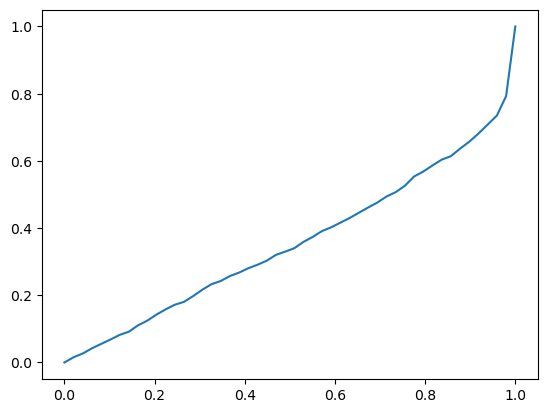

In [211]:
hits = []
for c in confidences:
    delta = calibration_adjustment * stds * norm.ppf(.5 + c / 2) / np.sqrt(len(ensemble))
    a = np.array((mean - delta < y_test) & (mean + delta > y_test)).astype(int)
    hits.append(a.sum() / len(a))

plt.plot(confidences, hits)
plt.yscale('linear')

#### Ranking based evaluation

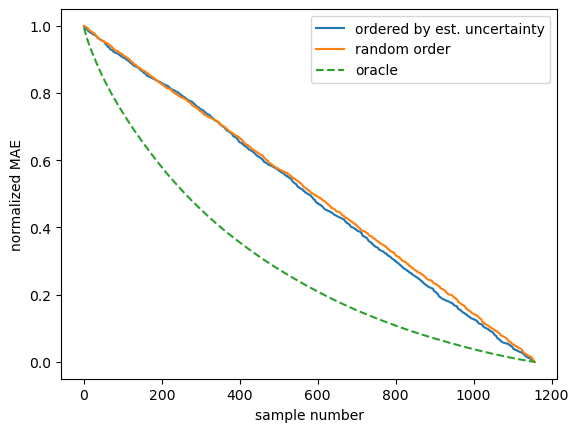

In [214]:
idcs_mae = np.argsort(mae)[::-1]
idcs_conf = np.argsort(stds)[::-1]
plt.plot((mae.sum() - np.cumsum(mae[idcs_conf])) / mae.sum(), label='ordered by est. uncertainty')
np.random.shuffle(idcs_conf)
plt.plot((mae.sum() - np.cumsum(mae[idcs_conf])) / mae.sum(), label='random order')
plt.plot((mae.sum() - np.cumsum(mae[idcs_mae])) / mae.sum(), '--', label='oracle')
plt.legend()
plt.xlabel('sample number')
plt.ylabel('normalized MAE');

### Bagging ensemble - Training a model with varying data

In [93]:
ensemble_size = 20
ensemble_bagg = []
for _ in tqdm.tqdm(range(ensemble_size)):
    idcs = np.random.choice(np.arange(len(x_train)), size=len(x_train), replace=True)
    x_train_resample = tf.gather(x_train, tf.constant(idcs))
    y_train_resample = tf.gather(y_train, tf.constant(idcs))
    model = create_and_fit_model(x_train_resample, y_train_resample, x_test, y_test,
                                 layers=[1024, 512, 256, 128, 64], verbose=0, batch_size=32, epochs=20)
    ensemble_bagg.append(model)

  0%|                                                                                                                                                                  | 0/20 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [6]:
preds_bagg = np.array([model.predict(x_test) for model in ensemble_bagg]).reshape(ensemble_size, len(x_test))

In [94]:
stds_bagg = preds_bagg.std(0)
var_bagg = preds_bagg.var(0)
mean_bagg = preds_bagg.mean(0)
mae_bagg = np.abs(preds_bagg - y_test).sum(0)
mse_bagg = np.sum((preds_bagg - y_test) ** 2, 0)

InvalidArgumentError: Incompatible shapes: [1158,20] vs. [1158] [Op:Sub]

In [13]:
np.corrcoef(mean_bagg, y_test)

array([[1.        , 0.83446551],
       [0.83446551, 1.        ]])

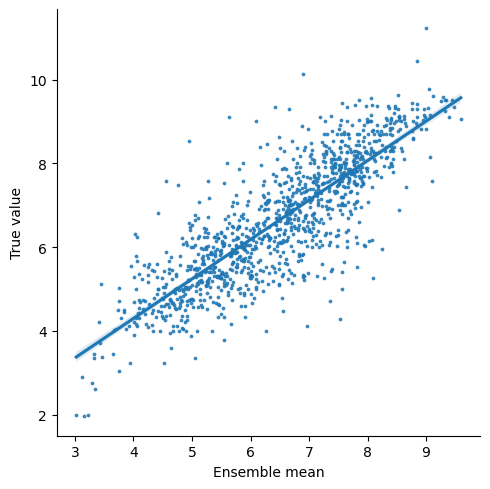

In [14]:
sns.lmplot(pd.DataFrame({'Ensemble mean': mean_bagg, 'True value': y_test}), x='Ensemble mean', y='True value', scatter_kws={'s': 3});

#### Calibration

In [92]:
preds_calibration = np.array([model.predict(x_test[:200]) for model in ensemble_bagg]).reshape(ensemble_size, 200)

stds_calibration = preds_calibration.std(0)
mean_calibration = preds_calibration.mean(0)
confidences = np.linspace(0, 1)
hits_calibration = []
for c in confidences:
    delta = stds_calibration * norm.ppf(.5 + c / 2) / np.sqrt(len(ensemble_bagg))
    a = np.array((mean_calibration - delta < y_test[:200]) & (mean_calibration + delta > y_test[:200])).astype(int)
    hits_calibration.append(a.sum() / len(a))
calibration_adjustment_bagg = (confidences / hits_calibration)[1:].mean()

NameError: name 'ensemble_bagg' is not defined

In [37]:
confidences = np.linspace(0, 1)
hits_bagg = []
for c in confidences:
    delta = calibration_adjustment_bagg * stds_bagg * norm.ppf(.5 + c / 2) / np.sqrt(len(ensemble_bagg))
    a = np.array((mean_bagg - delta < y_test) & (mean_bagg + delta > y_test)).astype(int)
    hits_bagg.append(a.sum() / len(a))

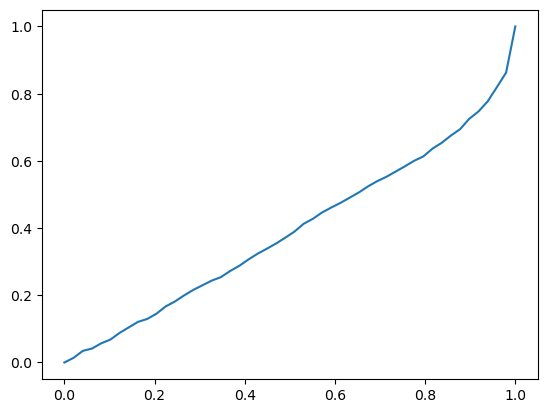

In [38]:
plt.plot(confidences, hits_bagg)
plt.yscale('linear')

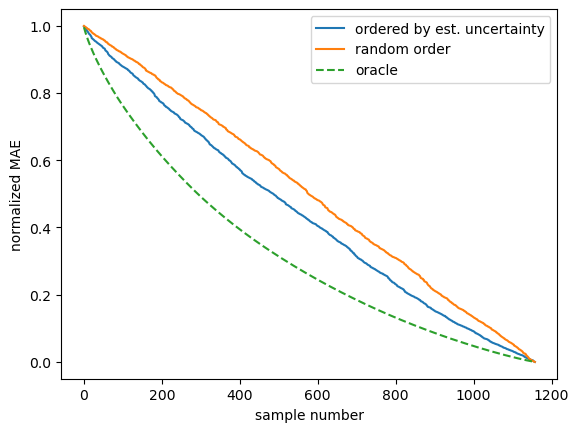

In [39]:
idcs_mae = np.argsort(mae_bagg)[::-1]
idcs_conf = np.argsort(stds_bagg)[::-1]
plt.plot((mae_bagg.sum() - np.cumsum(mae_bagg[idcs_conf])) / mae_bagg.sum(), label='ordered by est. uncertainty')
np.random.shuffle(idcs_conf)
plt.plot((mae_bagg.sum() - np.cumsum(mae_bagg[idcs_conf])) / mae_bagg.sum(), label='random order')
plt.plot((mae_bagg.sum() - np.cumsum(mae_bagg[idcs_mae])) / mae_bagg.sum(), '--', label='oracle')
plt.legend()
plt.xlabel('sample number')
plt.ylabel('normalized MAE');

#### Test data augmentation

In [6]:
model = create_and_fit_model(x_train, y_train, x_test, y_test,
                             layers=[1024, 512, 256, 128, 64], verbose=0, batch_size=32, epochs=20)

2022-12-15 12:40:54.996416: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-12-15 12:40:54.996721: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2299965000 Hz


In [110]:
augmented_testset = tf.tile(x_test, [20, 1]).numpy().astype(np.bool)
alterations = np.zeros(shape=augmented_testset.shape) < 1e-4

In [111]:
augmented_testset = np.logical_xor(alterations, augmented_testset)
augmented_testset = tf.convert_to_tensor(augmented_testset)

In [112]:
preds = model.predict(augmented_testset)

In [118]:
preds_bagg = preds.reshape(20, int(preds.shape[0] / 20))

In [119]:
y_test = y_test#.numpy().reshape(-1, 1)

stds_bagg = preds_bagg.std(0)
var_bagg = preds_bagg.var(0)
mean_bagg = preds_bagg.mean(0)
mae_bagg = np.abs(preds_bagg - y_test).sum(0)
mse_bagg = np.sum((preds_bagg - y_test) ** 2, 0)

ValueError: operands could not be broadcast together with shapes (20,1158) (1158,1) 

In [116]:
mae_bagg

array([49021.61911729, 49017.9099994 , 49021.61909822, 49017.91001466,
       49021.61911729, 49017.91000322, 49021.61914399, 49017.90993837,
       49021.61910585, 49017.9099994 , 49021.61904863, 49017.91004899,
       49021.61910585, 49017.9099994 , 49021.61908677, 49017.9100757 ,
       49021.61910585, 49017.90999559, 49021.61910966, 49017.90998414])

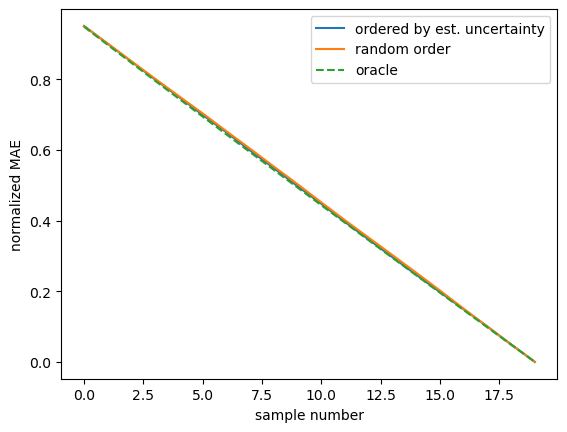

In [108]:
idcs_mae = np.argsort(mae_bagg)[::-1]
idcs_conf = np.argsort(stds_bagg)[::-1]
plt.plot((mae_bagg.sum() - np.cumsum(mae_bagg[idcs_conf])) / mae_bagg.sum(), label='ordered by est. uncertainty')
np.random.shuffle(idcs_conf)
plt.plot((mae_bagg.sum() - np.cumsum(mae_bagg[idcs_conf])) / mae_bagg.sum(), label='random order')
plt.plot((mae_bagg.sum() - np.cumsum(mae_bagg[idcs_mae])) / mae_bagg.sum(), '--', label='oracle')
plt.legend()
plt.xlabel('sample number')
plt.ylabel('normalized MAE');

## Discussion

Wrap up the talktorial's content here and discuss pros/cons and open questions/challenges.

## Quiz

Ask three questions that the user should be able to answer after doing this talktorial. Choose important take-aways from this talktorial for your questions.

1. Question
2. Question
3. Question

<div class="alert alert-block alert-info">

<b>Useful checks at the end</b>: 
    
<ul>
<li>Clear output and rerun your complete notebook. Does it finish without errors?</li>
<li>Check if your talktorial's runtime is as excepted. If not, try to find out which step(s) take unexpectedly long.</li>
<li>Flag code cells with <code># NBVAL_CHECK_OUTPUT</code> that have deterministic output and should be tested within our Continuous Integration (CI) framework.</li>
</ul>

</div>